### start

In [1]:
# pyright: reportMissingImports=false
# pyright: reportMissingModuleSource=false

import uuid
import random
import hashlib
import os
import sys
import gc
import time
import copy
import logging
import re
from itertools import chain,combinations
import pdb
import math
from pathlib import Path
import datetime
from datetime import datetime,timedelta
import json
import warnings
import yaml
from typing import Dict,Union,List,Any,Tuple
import pytest
import importlib
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import IPython
import requests
import warnings
import boto3
import matplotlib as plt
import sklearn

# load_dotenv(Path("../../../Local/.env"))

# Custom format function for displaying |numbers/
pd.set_option('display.float_format', lambda x: f'{x:.12g}')
# pd.reset_option('display.float_format')

# Suppress warnings
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
warnings.filterwarnings('ignore', message='.*frozen modules.*')
warnings.filterwarnings("ignore", message="MallocStackLogging")

# silence pygame donation request
os.environ['PYGAME_HIDE_SUPPORT_PROMPT'] = "hide"
os.environ['LOGGING_FILE'] = "../../../Local/logs/wallet_modeling.log"
os.environ['NOTIFICATION_SOUNDS_DIR'] = "../../../Local"

# Dark mode charts
plt.rcParams['figure.facecolor'] = '#181818'  # Custom background color (dark gray in this case)
plt.rcParams['axes.facecolor'] = '#181818'
plt.rcParams['text.color'] = '#afc6ba'
plt.rcParams['axes.labelcolor'] = '#afc6ba'
plt.rcParams['xtick.color'] = '#afc6ba'
plt.rcParams['ytick.color'] = '#afc6ba'
plt.rcParams['axes.titlecolor'] = '#afc6ba'
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.default'] = 'regular'

# import local modules
# pyright: reportMissingImports=false
sys.path.append('../src')

import sage_wallet_modeling.wallet_modeler as wm
from sage_wallet_modeling.wallet_preprocessor import SageWalletsPreprocessor
import sage_wallet_modeling.workflow_orchestrator as wo
import sage_wallet_insights.model_evaluation as sime

import sage_utils.config_validation as ucv
import sage_utils.s3_utils as s3u

# import data-science modules
sys.path.append(str(Path("..") / ".." / "data-science" / "src"))
import wallet_insights.model_evaluation as wime
import utils as u
from utils import ConfigError



# reload all modules
modules = [
    wm, wo,
    sime,
    ucv, s3u,
    wime,
    u,
]

# import utils as u
# Set the custom error handler
ipython = IPython.get_ipython()
# ipython.set_custom_exc((Exception,), u.notify_on_failure)

player = u.AmbientPlayer()
player.stop_all_players()

# configure logger
logger = u.setup_notebook_logger('../logs/notebook_logs.log')
logger.setLevel(logging.INFO)

from IPython.core import ultratb
ultratb.VerboseTB._tb_highlight = "bg:#b45827"


# load all configs
sage_wallets_config = ucv.load_sage_wallets_config(Path('../config/sage_wallets_config.yaml'))
sage_wallets_modeling_config = ucv.load_sage_wallets_modeling_config(Path('../config/sage_wallets_modeling_config.yaml'))


u.export_code(
    code_directories=[
        'sage_wallet_insights',
        'sage_wallet_modeling',
        # 'sage_utils',
    ],
    # include_config = True,
    # ipynb_notebook = 'DDA-769 coin model score dist toggle.ipynb'
    output_file="temp/sagemaker_code.py"
)

[importlib.reload(module) for module in modules]
u.notify('retro')

logger.milestone("Good morning, let's get to work")

sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/jeremymeadow/Library/Application Support/sagemaker/config.yaml


[30/Jul/25 16:18:17] INFO [utils.export_code:1659] Consolidation complete. All files are saved in temp/sagemaker_code.py
[30/Jul/25 16:18:17] MILESTONE [3934705018.<module>:127] Good morning, let's get to work


# Model Training

### Initiate orchestrator

In [13]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    '231107',
    '240306',
    '250301'
]
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)

### Load, preprocess, and upload all data

#### load data

In [14]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch.load_all_training_data(date_suffixes)

[29/Jul/25 18:45:29] MILESTONE [workflow_orchestrator.load_all_training_data:120] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[29/Jul/25 18:45:29] INFO [workflow_orchestrator.load_all_training_data:136] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.


##### inspect features

In [ ]:
# Create combined NaN count and describe statistics
first_key = next(iter(workflow_orch.training_data))
nan_counts = workflow_orch.training_data[first_key]['x_train'].isna().sum()
describe_stats = workflow_orch.training_data[first_key]['x_train'].describe().T

# Combine into single DataFrame
combined_stats = pd.concat([
    nan_counts.rename('nan_count'),
    describe_stats
], axis=1).sort_index()

u.display_full(combined_stats.sort_index())

#### preprocess data

In [15]:
workflow_orch.preprocess_all_training_data()

[29/Jul/25 18:45:32] INFO [workflow_orchestrator.preprocess_all_training_data:167] Preprocessing 4 date periods...
[29/Jul/25 18:45:32] INFO [wallet_preprocessor.preprocess_training_data:76] Starting preprocessing for SageMaker XGBoost compatibility...
[29/Jul/25 18:45:32] INFO [wallet_preprocessor._handle_missing_values:234] Filled NaN values in 100 columns for x_train.
[29/Jul/25 18:45:32] INFO [wallet_preprocessor._preprocess_y_data:271] Applied classification threshold 0.05 to y_train: 5,864 positive (29.7%), 13,874 negative (70.3%)
[29/Jul/25 18:45:32] INFO [wallet_preprocessor._combine_x_y_data:382] Merged y df with target var cw_crypto_net_gain/crypto_inflows/winsorized with X data.
[29/Jul/25 18:45:33] INFO [wallet_preprocessor._save_preprocessed_df:428] Saved preprocessed train split to ../s3_uploads/wallet_training_data_preprocessed/dda_897_td_column_ordering_v1/231008/train.csv
[29/Jul/25 18:45:33] INFO [wallet_preprocessor.preprocess_training_data:118] Preprocessed train: 1

#### upload data

In [16]:
# Upload and retrieve URIs
workflow_orch.upload_all_training_data(overwrite_existing=True)
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)

[29/Jul/25 18:46:01] MILESTONE [workflow_orchestrator._confirm_upload:621] <PROD> Ready to upload 372871 total rows (630.3 MB) of preprocessed training data across 4 date folders.
[29/Jul/25 18:46:01] INFO [workflow_orchestrator._confirm_upload:641] Target: s3://wallet-training-data/training-data-preprocessed/dda-899-classifier/[DATE]/
[29/Jul/25 18:46:09] INFO [workflow_orchestrator.upload_all_training_data:214] Beginning approved upload...
[29/Jul/25 18:46:09] INFO [workflow_orchestrator.upload_all_training_data:219] Uploading data for 4 date periods with 4 threads...
[29/Jul/25 18:50:01] INFO [workflow_orchestrator._upload_csv_files:689] Uploaded train to s3://wallet-training-data/training-data-preprocessed/dda-899-classifier/240306/train.csv
[29/Jul/25 18:50:10] INFO [workflow_orchestrator._upload_csv_files:689] Uploaded train to s3://wallet-training-data/training-data-preprocessed/dda-899-classifier/231008/train.csv
[29/Jul/25 18:50:20] INFO [workflow_orchestrator._upload_csv_file

### Train all models

In [17]:
workflow_orch.load_all_training_data(date_suffixes)
modeling_results = workflow_orch.train_all_models()

[29/Jul/25 20:12:31] MILESTONE [workflow_orchestrator.load_all_training_data:120] <PROD> Loading training data for 4 periods: ['231008', '231107', '240306', '250301']
[29/Jul/25 20:12:31] INFO [workflow_orchestrator.load_all_training_data:136] Training data loaded successfully: 745,742 total rows and 9 offsets for each date_suffix.
[29/Jul/25 20:12:32] INFO [workflow_orchestrator.train_all_models:331] Training models for 4 date periods with 4 threads...
[29/Jul/25 20:12:32] INFO [wallet_modeler.train_model:123] Starting SageMaker training sequence...
[29/Jul/25 20:12:32] INFO [wallet_modeler.train_model:123] Starting SageMaker training sequence...
[29/Jul/25 20:12:32] INFO [wallet_modeler.train_model:123] Starting SageMaker training sequence...
[29/Jul/25 20:12:32] INFO [wallet_modeler.train_model:123] Starting SageMaker training sequence...
[29/Jul/25 20:12:33] INFO [utils.request_confirmation:1681] Proceeding based on configuration: A model for 231008 already exists in s3://wallet-tr

2025-07-30 03:12:34 Starting - Starting the training job2025-07-30 03:12:34 Starting - Starting the training job.2025-07-30 03:12:35 Starting - Starting the training job..2025-07-30 03:12:37 Starting - Starting the training job.........
2025-07-30 03:13:08 Downloading - Downloading input data.
2025-07-30 03:13:10 Downloading - Downloading input data
2025-07-30 03:12:50 Starting - Preparing the instances for training..
2025-07-30 03:12:50 Starting - Preparing the instances for training..........
2025-07-30 03:13:12 Downloading - Downloading input data..
2025-07-30 03:13:13 Downloading - Downloading input data.........
2025-07-30 03:13:58 Downloading - Downloading the training image.
2025-07-30 03:14:00 Downloading - Downloading the training image.
2025-07-30 03:13:57 Downloading - Downloading the training image.
2025-07-30 03:13:58 Downloading - Downloading the training image.....................
2025-07-30 03:14:59 Training - Training image download completed. Training in progress..
20

[29/Jul/25 20:15:57] INFO [wallet_modeler._upload_training_artifacts:659] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-231107-20250729-201233/training_metadata.json
[29/Jul/25 20:15:57] INFO [wallet_modeler.train_model:163] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-231107-20250729-201233/output/model.tar.gz
[29/Jul/25 20:15:57] INFO [workflow_orchestrator._train_single_model:748] Successfully completed training for 231107


Training seconds: 150
Billable seconds: 150


[29/Jul/25 20:15:58] INFO [wallet_modeler._upload_training_artifacts:659] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-231008-20250729-201233/training_metadata.json
[29/Jul/25 20:15:58] INFO [wallet_modeler.train_model:163] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-231008-20250729-201233/output/model.tar.gz
[29/Jul/25 20:15:58] INFO [workflow_orchestrator._train_single_model:748] Successfully completed training for 231008


[8]#011train-aucpr:0.77154#011validation-aucpr:0.76656
[9]#011train-aucpr:0.77692#011validation-aucpr:0.77038
[10]#011train-aucpr:0.77951#011validation-aucpr:0.77057
[11]#011train-aucpr:0.78265#011validation-aucpr:0.77334
[12]#011train-aucpr:0.78655#011validation-aucpr:0.77469
[13]#011train-aucpr:0.79088#011validation-aucpr:0.77922
[14]#011train-aucpr:0.79475#011validation-aucpr:0.78213
[15]#011train-aucpr:0.79587#011validation-aucpr:0.78250
[16]#011train-aucpr:0.79771#011validation-aucpr:0.78235
[17]#011train-aucpr:0.80272#011validation-aucpr:0.78367
[18]#011train-aucpr:0.80432#011validation-aucpr:0.78411
[19]#011train-aucpr:0.80705#011validation-aucpr:0.78559
[20]#011train-aucpr:0.80956#011validation-aucpr:0.78664
[21]#011train-aucpr:0.81212#011validation-aucpr:0.78556
[22]#011train-aucpr:0.81503#011validation-aucpr:0.78603
[23]#011train-aucpr:0.81763#011validation-aucpr:0.78823
[24]#011train-aucpr:0.81926#011validation-aucpr:0.78873
[25]#011train-aucpr:0.82061#011validation-aucpr:0.

[29/Jul/25 20:17:00] INFO [wallet_modeler._upload_training_artifacts:659] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-250301-20250729-201233/training_metadata.json
[29/Jul/25 20:17:00] INFO [wallet_modeler.train_model:163] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-250301-20250729-201233/output/model.tar.gz
[29/Jul/25 20:17:00] INFO [wallet_modeler._upload_training_artifacts:659] Training artifacts saved to s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-240306-20250729-201233/training_metadata.json
[29/Jul/25 20:17:00] INFO [wallet_modeler.train_model:163] Training completed. Model stored at: s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-240306-20250729-201233/output/model.tar.gz
[29/Jul/25 20:17:01] INFO [workflow_orchestrator._train_si

### Train Single Model

#### retrieve file uris

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)

# Generate URIs for specific dates without any prior setup
s3_uris = workflow_orch.retrieve_training_data_uris(date_suffixes)
s3_uris

#### train model

In [ ]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))

date_suffix = date_suffixes[0]

modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)



In [ ]:
modeling_results = modeler.train_model()

### Score validation set

#### get existing model uri

In [27]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))



date_suffix = '231008'

# Generate URIs for specific dates without any prior setup
workflow_orch = wo.WalletWorkflowOrchestrator(sage_wallets_config,sage_wallets_modeling_config)
s3_uris = workflow_orch.retrieve_training_data_uris([date_suffix])

# Launch modeler
modeler = wm.WalletModeler(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    s3_uris
)


model_metadata = modeler.load_existing_model()

[29/Jul/25 22:07:20] INFO [wallet_modeler.load_existing_model:240] Loaded most recent model (timestamp: 20250729-201233): s3://wallet-training-data/sagemaker-models/dda-899-classifier/wallet-xgb-dda-899-classifier-231008-20250729-201233/output/model.tar.gz


#### predict with batch transform

In [30]:
transform_results = modeler.predict_with_batch_transform('val')

[29/Jul/25 22:14:43] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[29/Jul/25 22:14:43] INFO [session.submit:4105] Creating model with name: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:14:43] WARNING [session.submit:4116] Using already existing model: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:14:44] INFO [wallet_modeler._execute_batch_transform:765] Starting batch transform job: wallet-scoring-231008-221443
[29/Jul/25 22:14:44] INFO [wallet_modeler._execute_batch_transform:766] Using model: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:14:44] INFO [wallet_modeler._execute_batch_transform:767] Input data: s3://wallet-training-data/training-data-preprocessed/dda-899-classifier/231008/val.csv
[29/Jul/25 22:14:44] INFO [wallet_modeler._execute_batch_transform:768] Output path: s3://wallet-training-data/validation-data-scored/dda-899-classifier/231008/wallet-scoring-231008-221443
[29/Jul/25 22:

.............................../miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-07-30:05:20:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-07-30:05:20:01:INFO] No GPUs detected (normal if no gpus installed)
[2025-07-30:05:20:01:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|inv

[29/Jul/25 22:20:45] INFO [wallet_modeler._execute_batch_transform:781] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-899-classifier/231008/wallet-scoring-231008-221443/val.csv.out
[29/Jul/25 22:20:45] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_897_td_column_ordering_v1/231008/val.csv.out.
[29/Jul/25 22:20:45] INFO [wallet_modeler._download_batch_transform_preds:812] Downloaded val predictions to: None


In [28]:
transform_results = modeler.predict_with_batch_transform('test')

[29/Jul/25 22:07:25] INFO [image_uris._processor:530] Ignoring unnecessary instance type: None.
[29/Jul/25 22:07:25] INFO [session.submit:4105] Creating model with name: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:07:26] WARNING [session.submit:4116] Using already existing model: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:07:26] INFO [wallet_modeler._execute_batch_transform:765] Starting batch transform job: wallet-scoring-231008-220726
[29/Jul/25 22:07:26] INFO [wallet_modeler._execute_batch_transform:766] Using model: wallet-xgb-dda-899-classifier-231008-20250729-201233
[29/Jul/25 22:07:26] INFO [wallet_modeler._execute_batch_transform:767] Input data: s3://wallet-training-data/training-data-preprocessed/dda-899-classifier/231008/test.csv
[29/Jul/25 22:07:26] INFO [wallet_modeler._execute_batch_transform:768] Output path: s3://wallet-training-data/validation-data-scored/dda-899-classifier/231008/wallet-scoring-231008-220726
[29/Jul/25 22

................................/miniconda3/lib/python3.9/site-packages/sagemaker_containers/_server.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
[2025-07-30:05:12:48:INFO] No GPUs detected (normal if no gpus installed)
[2025-07-30:05:12:48:INFO] No GPUs detected (normal if no gpus installed)
[2025-07-30:05:12:48:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|in

[29/Jul/25 22:13:29] INFO [wallet_modeler._execute_batch_transform:781] Batch transform completed. Predictions at: s3://wallet-training-data/validation-data-scored/dda-899-classifier/231008/wallet-scoring-231008-220726/test.csv.out
[29/Jul/25 22:13:30] INFO [s3_utils.download_from_uri:69] Stored file at ..//s3_downloads/wallet_predictions/dda_897_td_column_ordering_v1/231008/test.csv.out.
[29/Jul/25 22:13:30] INFO [wallet_modeler._download_batch_transform_preds:812] Downloaded test predictions to: None


### Predict Using Endpoints

#### deploy endpoint for predictions

In [ ]:
modeler.list_active_endpoints()

In [ ]:
modeler.deploy_endpoint()

#### load and preprocess test/val dfs

In [ ]:
x_test = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_test_{date_suffix}.parquet"
)
x_val = pd.read_parquet(
    Path("../s3_uploads/wallet_training_data_queue") /
    sage_wallets_config['training_data']['local_directory'] /
    f"x_val_{date_suffix}.parquet"
)




In [ ]:
preprocessor = SageWalletsPreprocessor(sage_wallets_config)
x_test_processed = preprocessor.preprocess_x_df(x_test)
x_val_processed = preprocessor.preprocess_x_df(x_val)

logger.info(f"Preprocessed X_test {x_test_processed.shape} and "
            f"X_val {x_val_processed.shape}.")

#### predict

In [ ]:
y_test_pred = modeler.predict_using_endpoint(x_test_processed, 'test')
y_val_pred = modeler.predict_using_endpoint(x_val_processed, 'val')

#### delete all endpoints

In [ ]:
modeler.delete_all_endpoints()

In [ ]:
modeler.list_active_endpoints()
modeler.list_all_endpoints()

# Model Evaluation

### Analyze predictions

In [2]:
[importlib.reload(module) for module in modules]
sage_wallets_config = yaml.safe_load(Path('../config/sage_wallets_config.yaml').read_text(encoding='utf-8'))
sage_wallets_modeling_config = yaml.safe_load(Path('../config/sage_wallets_modeling_config.yaml').read_text(encoding='utf-8'))


date_suffixes = [
    '231008',
    # '240306'
]
date_suffix = date_suffixes[0]

In [4]:
y_test_pred = sime.load_bt_sagemaker_predictions('test', sage_wallets_config, date_suffix)
y_val_pred = sime.load_bt_sagemaker_predictions('val', sage_wallets_config, date_suffix)

[30/Jul/25 16:19:21] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to train: 5,864 positive (29.7%), 13,874 negative (70.3%)
[30/Jul/25 16:19:21] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to test: 1,125 positive (30.4%), 2,577 negative (69.6%)
[30/Jul/25 16:19:21] INFO [wallet_preprocessor.preprocess_y_data:274] Applied classification threshold 0.05 to val: 12,020 positive (60.3%), 7,927 negative (39.7%)
[30/Jul/25 16:19:21] INFO [model_evaluation.summary_report:1094] 
Model Performance Summary
Objective: mock_objective
Target: cw_crypto_net_gain/crypto_inflows/winsorized  to 
ID: sagemaker_dda_897_td_column_ordering_v1_231008
Test Samples:             3,702
Val Positive Samples:     12,020 (60.3%)
Number of Features:       221
Features per Window:      54

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.400  |  0.866
Val Accuracy:  

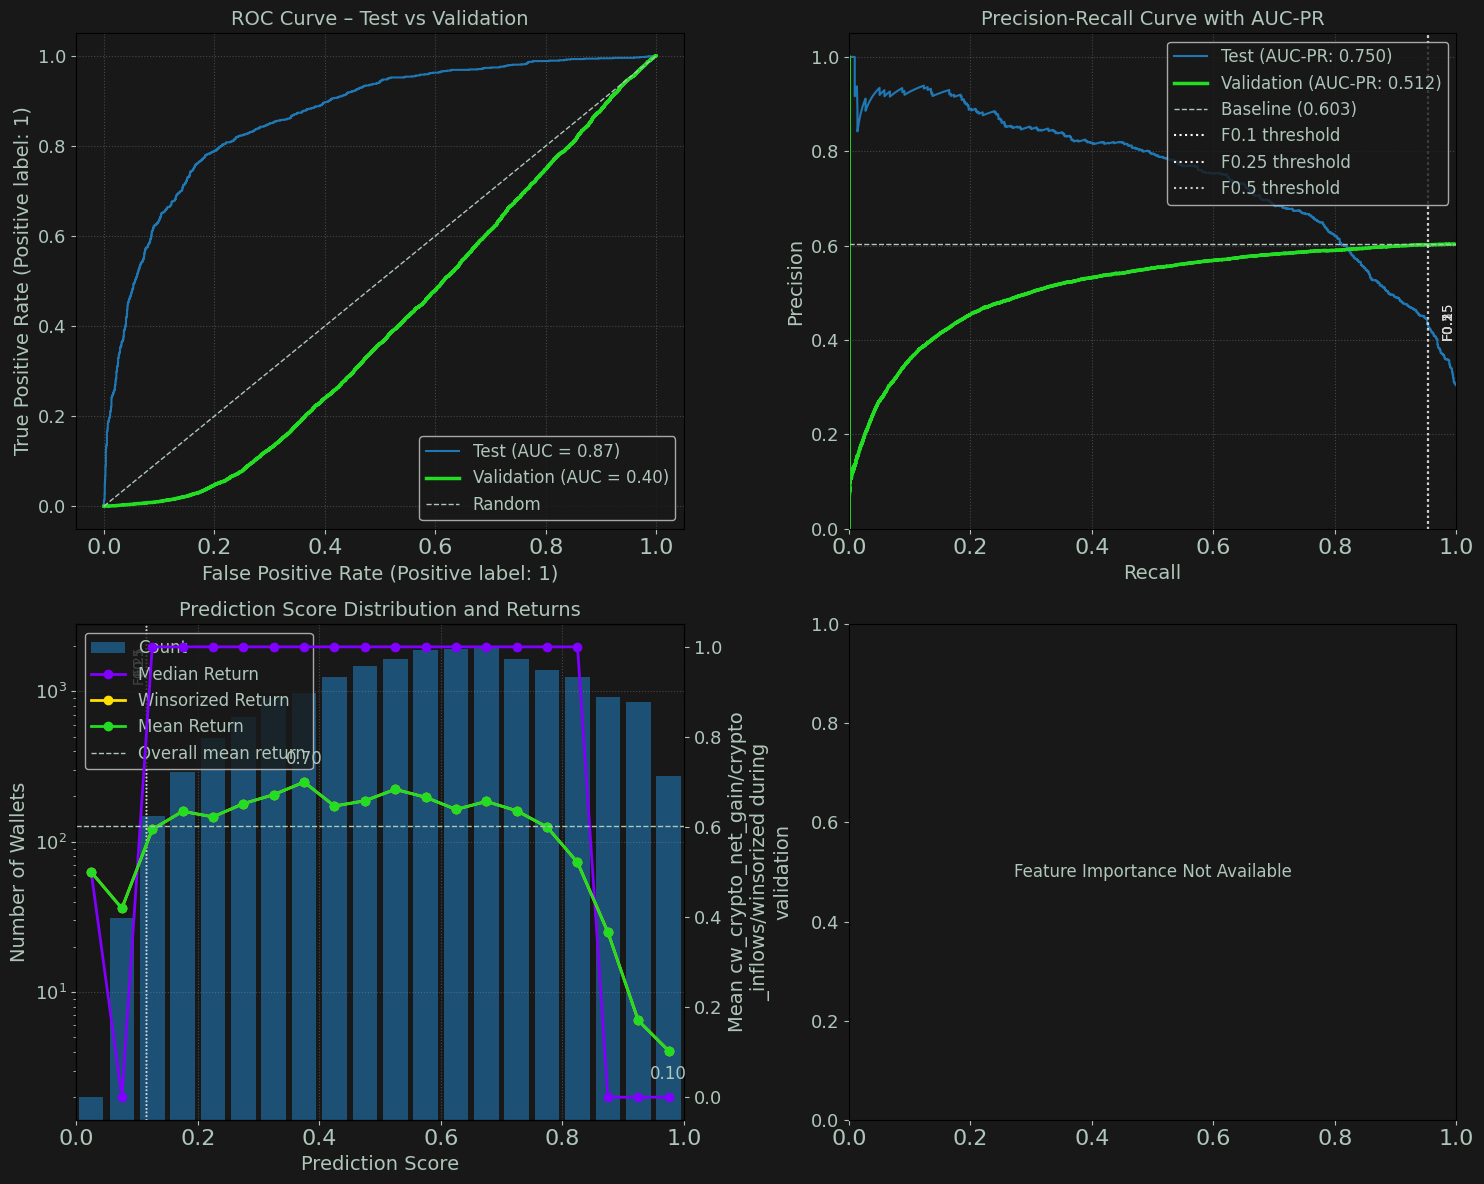

In [5]:
# Single function call for complete evaluation
evaluator = sime.run_sagemaker_evaluation(
    sage_wallets_config,
    sage_wallets_modeling_config,
    date_suffix,
    y_test_pred,
    y_val_pred
)

In [35]:
evaluator.y_validation

wallet_address  epoch_start_date
3000006450      2023-11-07         0 
3000006451      2023-11-07         1 
3000026925      2023-11-07         0 
3000093283      2023-11-07         0 
3000115628      2023-11-07         0 
                                   ..
3113690375      2023-11-07         1 
3113690779      2023-11-07         0 
3113690783      2023-11-07         1 
3113691333      2023-11-07         0 
3113721711      2023-11-07         0 
Name: cw_crypto_net_gain/crypto_inflows/winsorized, Length: 19947, dtype: float32

In [36]:
evaluator.y_validation_pred_proba

wallet_address  epoch_start_date
3000006450      2023-11-07         0.573660492897
3000006451      2023-11-07         0.266436368227
3000026925      2023-11-07         0.788389325142
3000093283      2023-11-07         0.348261207342
3000115628      2023-11-07         0.565139353275
                                        ...      
3113690375      2023-11-07         0.660594344139
3113690779      2023-11-07         0.791958928108
3113690783      2023-11-07          0.89873957634
3113691333      2023-11-07          0.78609085083
3113721711      2023-11-07          0.93622303009
Length: 19947, dtype: float64

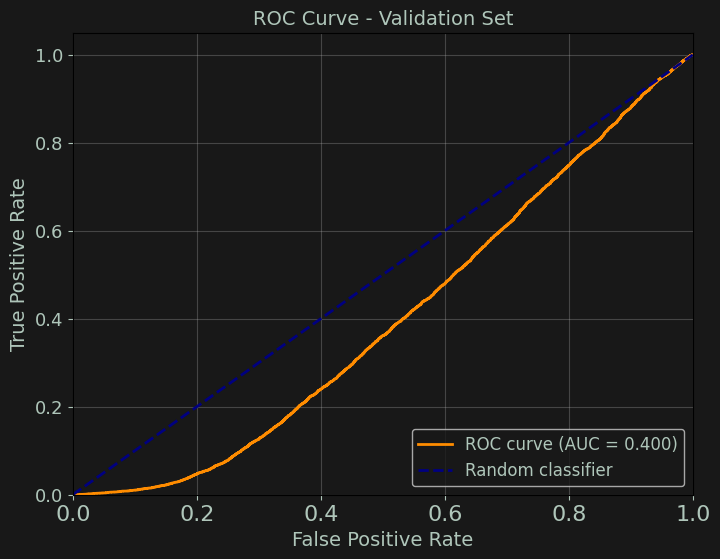

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(evaluator.y_validation, evaluator.y_validation_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

[30/Jul/25 15:55:06] INFO [model_evaluation.summary_report:1094] 
Model Performance Summary
Objective: mock_objective
Target: cw_crypto_net_gain/crypto_inflows/winsorized  to 
ID: sagemaker_dda_897_td_column_ordering_v1_231008
Test Samples:             3,702
Val Positive Samples:     12,020 (60.3%)
Number of Features:       221
Features per Window:      54

Classification Metrics:      Val   |  Test
-------------------------------------------
Val ROC AUC:                0.400  |  0.866
Val Accuracy:               0.505  |  0.818
Val Precision:              0.578  |  0.755
Val Recall:                 0.660  |  0.593
Val F1 Score:               0.616  |  0.664

Validation Returns    | Cutoff |  Mean   |  W-Mean
--------------------------------------------------
Overall Average       |    n/a |   0.603 |   0.603
Param Threshold       |   0.50 |   0.578 |   0.578
5 Highest Scores      |   0.98 |   0.000 |   0.000
Top 1% Scores         |   0.95 |   0.085 |   0.085
Top 5% Scores         |   

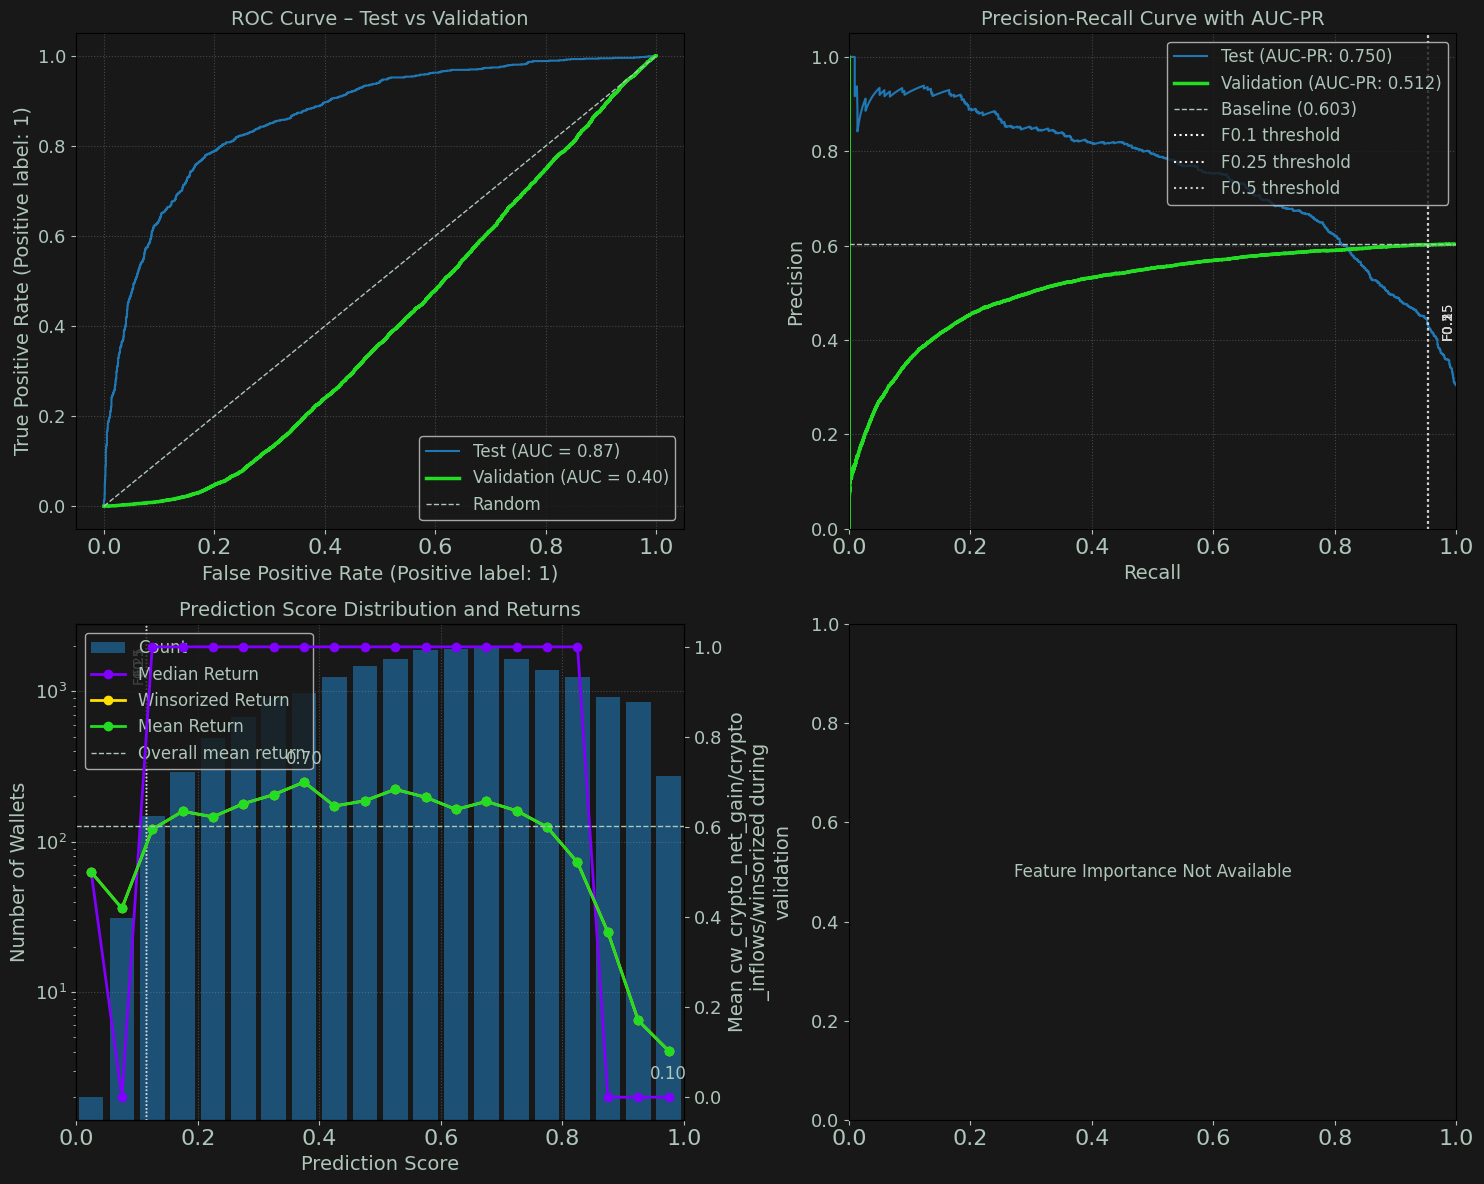

In [33]:
evaluator.summary_report()
evaluator.plot_wallet_evaluation()


In [ ]:
def load_sagemaker_predictions(
    data_type: str,
    sage_wallets_config: dict,
    sage_wallets_modeling_config: dict,
    date_suffix: str
) -> tuple[pd.Series, pd.Series]:
    """
    Load SageMaker predictions and corresponding actuals for a given data type.

    Params:
    - data_type (str): Either 'test' or 'val'
    - sage_wallets_config (dict): Configuration for training data paths
    - sage_wallets_modeling_config (dict): Configuration for model parameters
    - date_suffix (str): Date suffix for file naming

    Returns:
    - tuple: (predictions_series, actuals_series) with aligned indices
    """
    # Load predictions
    pred_path = Path(sage_wallets_modeling_config['metaparams']['endpoint_preds_dir']) / \
                f"endpoint_y_pred_{data_type}_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}.csv"
    pred_df = pd.read_csv(pred_path)

    if 'score' not in pred_df.columns:
        raise ValueError(f"SageMaker predictions are missing the 'score' column. "
                        f"Available columns: {pred_df.columns}")
    pred_series = pred_df['score']

    # Load actuals
    training_data_path = (
        Path(f"../s3_uploads") / "wallet_training_data_queue" /
        f"{sage_wallets_config['training_data']['local_directory']}"
    )
    actuals_path = training_data_path / f"y_{data_type}_{date_suffix}.parquet"
    actuals_df = pd.read_parquet(actuals_path)

    if len(actuals_df.columns) > 1:
        raise ValueError(f"Found unexpected columns in y_{data_type}_df. "
                        f"Expected 1 column, found {actuals_df.columns}.")
    actuals_series = actuals_df.iloc[:, 0]

    # Validate lengths and align indices
    if len(pred_series) != len(actuals_series):
        raise ValueError(f"Length of y_{data_type}_pred ({len(pred_series)}) does "
                        f"not match length of y_{data_type}_true ({len(actuals_series)}).")

    pred_series.index = actuals_series.index

    return pred_series, actuals_series

In [ ]:
# Load predictions and actuals
y_test_pred_series, y_test_true_series = load_sagemaker_predictions(
    'test', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)
y_val_pred_series, y_val_true_series = load_sagemaker_predictions(
    'val', sage_wallets_config, sage_wallets_modeling_config, date_suffix
)

# Load remaining training data
training_data_path = (
    Path(f"../s3_uploads") / "wallet_training_data_queue" /
    f"{sage_wallets_config['training_data']['local_directory']}"
)
X_train = pd.read_parquet(training_data_path / f"x_train_{date_suffix}.parquet")
y_train = pd.read_parquet(training_data_path / f"y_train_{date_suffix}.parquet")
X_test = pd.read_parquet(training_data_path / f"x_test_{date_suffix}.parquet")
X_val = pd.read_parquet(training_data_path / f"x_val_{date_suffix}.parquet")

# Identify target variable and model type
target_variable = y_val_true_series.name or y_train.columns[0]
objective = sage_wallets_modeling_config['training']['hyperparameters']['objective']
model_type = 'regression' if objective[:3] == 'reg' else 'unknown'

In [ ]:
# Create model_id and modeling_config
model_id = f"sagemaker_{sage_wallets_config['training_data']['local_directory']}_{date_suffix}"

modeling_config = {
    'target_variable': target_variable,
    'model_type': model_type,
    'returns_winsorization': 0.005,  # Default for winsorizing returns
    'training_data': {
        'modeling_period_duration': 30  # Default performance window
    },
    'sagemaker_metadata': {
        'objective': objective,
        'local_directory': sage_wallets_config['training_data']['local_directory'],
        'date_suffix': date_suffix
    }
}

# Create minimal wallet_model_results for SageMaker evaluation
wallet_model_results = {
    'model_id': model_id,
    'modeling_config': modeling_config,
    'model_type': model_type,

    # Training data
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test_true_series,
    'y_pred': y_test_pred_series,
    'training_cohort_pred': None,
    'training_cohort_actuals': None,

    # Validation data
    'X_validation': X_val,
    'y_validation': y_val_true_series,
    'y_validation_pred': y_val_pred_series,
    'validation_target_vars_df': None,

    # Fixed mock pipeline
    'pipeline': type('MockPipeline', (), {
        'named_steps': {'estimator': type('MockModel', (), {
            'get_params': lambda self: {'objective': objective}  # Accept self argument
        })()},
        '__getitem__': lambda self, key: type('MockTransformer', (), {
            'transform': lambda self, X: X  # Accept self argument
        })()
    })()
}

# Create evaluator
wallet_evaluator = wime.RegressorEvaluator(wallet_model_results)

# Run basic evaluation
wallet_evaluator.summary_report()
wallet_evaluator.plot_wallet_evaluation()

In [ ]:
target_variable